
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/039_RNN_LSTM_Sequence_Models.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/39_RNN_LSTM_Sequence_Models.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🔄 RNN & LSTM: Sieci z Pamięcią

Standardowa sieć (Feed-Forward) przyjmuje wejście i wypluwa wyjście. Koniec.
Sieć Rekurencyjna (RNN) robi pętlę: **Wyjście z kroku 1 staje się dodatkowym wejściem dla kroku 2.**

Dzięki temu sieć "pamięta", co widziała chwilę temu.

**Problem RNN:**
Zwykłe RNN mają "krótką pamięć" (problem znikającego gradientu). Pamiętają 5-10 kroków wstecz, ale zapominają początek długiej książki.

**Rozwiązanie: LSTM (Long Short-Term Memory).**
To neuron na sterydach. Posiada "bramki" (Gates):
1.  **Zapominania (Forget Gate):** Co wyrzucić z pamięci? (np. stary kontekst).
2.  **Wejścia (Input Gate):** Co zapisać nowego?
3.  **Wyjścia (Output Gate):** Co przekazać dalej?

W tym notatniku nauczymy sieć przewidywać **Sinusoidę** (szereg czasowy).

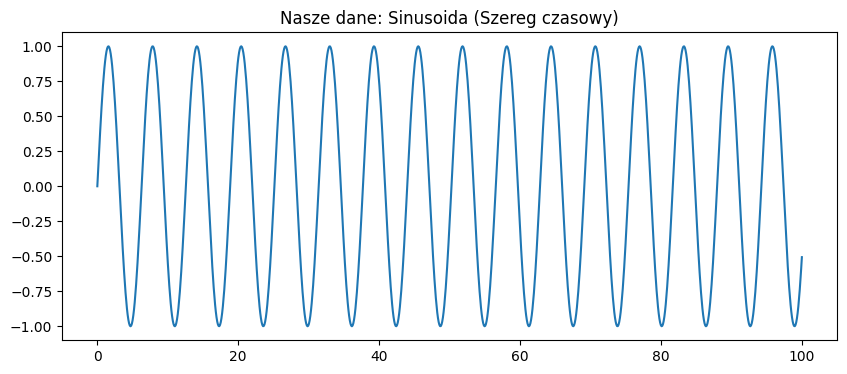

Liczba punktów: 1000


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. GENERUJEMY DANE (Sinusoida)
# Wyobraź sobie, że to kurs akcji albo temperatura.
t = np.linspace(0, 100, 1000)
data = np.sin(t)

# Wizualizacja
plt.figure(figsize=(10, 4))
plt.plot(t, data)
plt.title("Nasze dane: Sinusoida (Szereg czasowy)")
plt.show()

print(f"Liczba punktów: {len(data)}")

## Przygotowanie Danych (Sliding Window)

Sieci LSTM wymagają specyficznego formatu danych. Nie wrzucamy całej fali naraz.
Tniemy ją na **okna (Windows)**.

*   **Input (X):** 50 poprzednich punktów.
*   **Target (y):** 1 następny punkt.

Przykład:
`[0, 1, 2 ... 49]` -> Przewiduj `50`
`[1, 2, 3 ... 50]` -> Przewiduj `51`

In [2]:
# Konfiguracja
window_size = 50

def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        # Bierzemy okno o długości 50
        seq = data[i : i + window_size]
        # Bierzemy następny punkt jako cel
        label = data[i + window_size]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

X, y = create_sequences(data, window_size)

# Konwersja na Tensory PyTorch
# WAŻNE: LSTM oczekuje kształtu (Batch_Size, Sequence_Length, Input_Size)
# My mamy jedną cechę (wartość sinusa), więc Input_Size = 1.
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1) # Dodajemy wymiar: [950, 50] -> [950, 50, 1]
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Podział (Pierwsze 800 na trening, reszta na test)
train_size = 800
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Kształt X_train: {X_train.shape} -> (Próbki, Długość okna, Liczba cech)")

Kształt X_train: torch.Size([800, 50, 1]) -> (Próbki, Długość okna, Liczba cech)


## Budowa Modelu LSTM

Użyjemy warstwy `nn.LSTM`.
Zwraca ona dwie rzeczy:
1.  `out`: Wyniki dla każdego kroku czasowego.
2.  `hidden`: Stan ukryty (pamięć) po ostatnim kroku.

Nas interesuje tylko **ostatni wynik** z sekwencji (co będzie po 50 krokach?), więc bierzemy `out[:, -1, :]`.

In [3]:
class SineLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        
        # WARSTWA 1: LSTM
        # hidden_size=50 oznacza, że "pamięć" ma pojemność 50 liczb.
        # batch_first=True oznacza, że dane wchodzą jako (Batch, Seq, Features)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # WARSTWA 2: Linear (Tłumacz)
        # Zamienia pamięć LSTM na jedną liczbę (przewidywaną wartość sinusa)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (Batch, 50, 1)
        
        # LSTM zwraca: output, (hidden_state, cell_state)
        lstm_out, _ = self.lstm(x) 
        
        # Bierzemy wynik tylko z OSTATNIEGO kroku czasowego (-1)
        last_step = lstm_out[:, -1, :]
        
        # Przepuszczamy przez warstwę liniową
        prediction = self.linear(last_step)
        
        return prediction

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SineLSTM().to(device)
print(model)

SineLSTM(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [4]:
# Trening (Standardowa pętla PyTorch)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss() # Błąd średniokwadratowy (bo to regresja)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 100

for epoch in range(epochs):
    model.train()
    
    # 1. Forward
    y_pred = model(X_train)
    
    # 2. Loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoka {epoch} | Loss: {loss.item():.5f}")

print("✅ Trening zakończony.")

Epoka 0 | Loss: 0.48898
Epoka 10 | Loss: 0.03214
Epoka 20 | Loss: 0.00290
Epoka 30 | Loss: 0.00052
Epoka 40 | Loss: 0.00098
Epoka 50 | Loss: 0.00010
Epoka 60 | Loss: 0.00009
Epoka 70 | Loss: 0.00007
Epoka 80 | Loss: 0.00003
Epoka 90 | Loss: 0.00002
✅ Trening zakończony.


## Test: Czy model przewiduje przyszłość?

Zrobimy teraz coś trudnego: **Autoregresję**.
Zamiast dawać modelowi prawdziwe dane do przewidywania, każemy mu przewidywać na podstawie **własnych poprzednich przewidywań**.

To tak, jakbyś napisał jedno słowo książki, a potem pisał kolejne tylko na podstawie tego, co sam wymyśliłeś. Jeśli model jest słaby, wykres szybko się "rozjedzie".

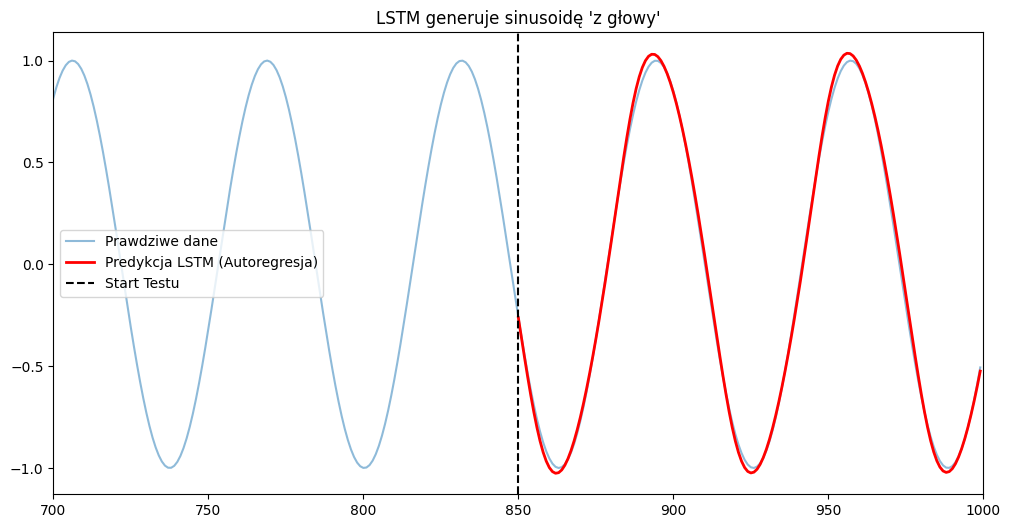

In [5]:
model.eval()

# Zaczynamy od pierwszego okna testowego
current_sequence = X_test[0].unsqueeze(0) # [1, 50, 1]
predictions = []

# Przewidujemy 150 kroków w przyszłość (więcej niż mamy danych testowych!)
with torch.no_grad():
    for _ in range(150):
        # Przewiduj następny punkt
        pred = model(current_sequence)
        predictions.append(pred.item())
        
        # Aktualizuj okno: Wyrzuć najstarszy punkt, dodaj nowy (predykcję)
        # To jest "przesuwne okno"
        new_point = pred.unsqueeze(1) # [1, 1, 1]
        current_sequence = torch.cat((current_sequence[:, 1:, :], new_point), dim=1)

# Wizualizacja
plt.figure(figsize=(12, 6))

# Prawdziwe dane (cała sinusoida)
plt.plot(np.arange(len(data)), data, label='Prawdziwe dane', alpha=0.5)

# Nasze predykcje (zaczynają się tam, gdzie kończy trening)
x_range_future = np.arange(train_size + window_size, train_size + window_size + 150)
plt.plot(x_range_future, predictions, label='Predykcja LSTM (Autoregresja)', color='red', linewidth=2)

plt.axvline(train_size + window_size, color='k', linestyle='--', label='Start Testu')
plt.legend()
plt.title("LSTM generuje sinusoidę 'z głowy'")
plt.xlim(700, 1000)
plt.show()

## 🧠 Podsumowanie: Pamięć kosztuje

Jeśli czerwona linia pokrywa się z niebieską (nawet po prawej stronie kreski startu), to znaczy, że **model zrozumiał cykliczność**. Nauczył się pojęcia "fali", a nie tylko zapamiętał punkty.

**Tu jest haczyk (Sekwencyjność).**
Trenowanie LSTM jest powolne. Dlaczego?
Bo nie da się tego zrównoleglić. Żeby policzyć krok 50, musisz znać wynik kroku 49. Musisz iść po kolei.
Właśnie dlatego wymyślono **Transformery** (Attention), które widzą całe zdanie naraz (równolegle). Ale do prostych szeregów czasowych (giełda, pogoda, sensory IOT) LSTM nadal jest królem.